1. Import and Install Dependencies

1.1 Install Dependencies

In [ ]:
!pip install tensorflow matplotlib tensorflow-io

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
from sklearn import preprocessing
import random as rn
from keras.layers import Dense
from keras import Input
from tensorflow.keras.models import Model
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D
import tensorflow as tf
import random

2. Data Loading

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-10-22 15:12:59.186137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 15:12:59.384077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 15:12:59.384140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3072)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-10-22 15:13:02.005220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 15:13:02.005400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 15:13:02.005437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 15:13:03.402158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 15:13:03.402185: I tensorflow/core/co

In [5]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
DATA_DIR = os.path.join('data', 'train/')

In [17]:
wav, sr = librosa.load(DATA_DIR + 'Q-01.wav', sr=16000)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 16000
wav shape: (7040,)
length: 0.44 secs


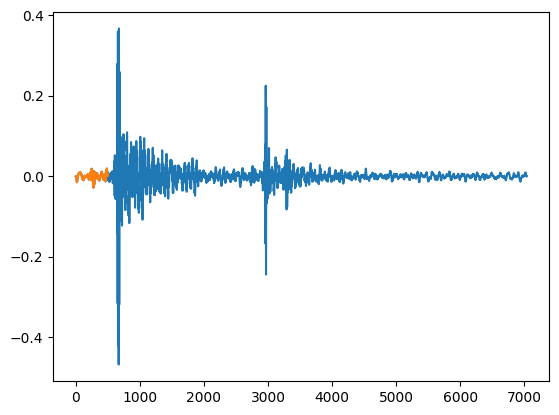

In [18]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

In [19]:
# Data set list, include (raw data, mfcc data, y data)
trainset = []
testset = []

# split each set into raw data, mfcc data, and y data
# STFT 한 것, CNN 분석하기 위해 Spectogram으로 만든 것, MF한 것, mel0spectogram 한 것
train_X = []
train_mfccs = []
train_y = []

test_X = []
test_mfccs = []
test_y = []

# 모든 음성파일의 길이가 같도록 후위에 padding 처리
pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i-a.shape[0])))
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))

frame_length = 0.025
frame_stride = 0.0010

In [137]:
from sklearn.model_selection import train_test_split

def get_mfcc(filename):
  wav, sr = librosa.load(filename, sr=16000)
  mfcc = librosa.feature.mfcc(y=wav, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
  mfcc = mfcc/ 1000000
  mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
  padded_mfcc = pad2d(mfcc, 40)
  return padded_mfcc


def get_labels(filename):
  if filename[0] == 'Q':
    return 0
  elif filename[0] == 'W':
    return 1
  elif filename[0] == 'E':
    return 2
  elif filename[0] == 'R':
    return 3


X = []
y = []

for filename in os.listdir(DATA_DIR):
  # wav 포맷 데이터만 사용
  if '.wav' not in filename:
    continue
  mfcc = get_mfcc(DATA_DIR + filename)
  label = get_labels(filename)
  X.append(mfcc)
  y.append(label)

train_mfccs, test_mfccs, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)


In [138]:
train_mfccs = np.array(train_mfccs)
train_y = to_categorical(np.array(train_y))

test_mfccs = np.array(test_mfccs)
test_y = to_categorical(np.array(test_y))

print('train_mfccs:', train_mfccs.shape)
print('train_y:', train_y.shape)

print('test_mfccs:', test_mfccs.shape)
print('test_y:', test_y.shape)

train_mfccs: (104, 100, 40)
train_y: (104, 4)
test_mfccs: (27, 100, 40)
test_y: (27, 4)


MFCC feature로 학습

In [139]:
train_X_ex = np.expand_dims(train_mfccs, -1)
test_X_ex = np.expand_dims(test_mfccs, -1)
print('train X shape:', train_X_ex.shape)
print('test X shape:', test_X_ex.shape)

train X shape: (104, 100, 40, 1)
test X shape: (27, 100, 40, 1)


In [140]:
ip = Input(shape=train_X_ex[0].shape)

m = Conv2D(32, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Conv2D(32*2, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Conv2D(32 * 3, kernel_size=(4, 4), activation='relu', input_shape=(10, 1, 64))(m)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Flatten()(m)

m = Dense(64, activation='relu')(m)

m = Dense(32, activation='relu')(m)

op = Dense(4, activation='softmax')(m)

model = Model(ip, op)

model.summary()
     

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100, 40, 1)]      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 97, 37, 64)        1088      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 24, 9, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 21, 6, 96)         98400     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 5, 1, 96)          0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 480)               0   

In [141]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
                    train_y,
                    epochs=100,
                    batch_size=32,
                    verbose=1,
                    validation_data=(test_X_ex, test_y))


Epoch 1/100
4/4 [==============================] - 2s 99ms/step - loss: 1.5046 - accuracy: 0.2212 - val_loss: 1.3998 - val_accuracy: 0.2963
Epoch 2/100
4/4 [==============================] - 0s 44ms/step - loss: 1.3946 - accuracy: 0.2596 - val_loss: 1.3791 - val_accuracy: 0.2963
Epoch 3/100
4/4 [==============================] - 0s 19ms/step - loss: 1.3926 - accuracy: 0.2404 - val_loss: 1.3763 - val_accuracy: 0.2222
Epoch 4/100
4/4 [==============================] - 0s 18ms/step - loss: 1.3748 - accuracy: 0.3173 - val_loss: 1.4027 - val_accuracy: 0.2222
Epoch 5/100
4/4 [==============================] - 0s 18ms/step - loss: 1.3802 - accuracy: 0.3846 - val_loss: 1.4080 - val_accuracy: 0.2222
Epoch 6/100
4/4 [==============================] - 0s 19ms/step - loss: 1.3600 - accuracy: 0.3654 - val_loss: 1.3668 - val_accuracy: 0.2963
Epoch 7/100
4/4 [==============================] - 0s 20ms/step - loss: 1.3557 - accuracy: 0.2404 - val_loss: 1.3691 - val_accuracy: 0.2963
Epoch 8/100
4/4 [===

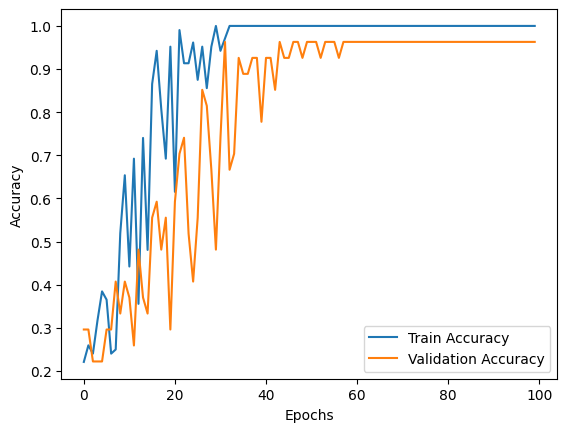

In [142]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [143]:
model.save('/home/hyochung/Keyboard_DL')

INFO:tensorflow:Assets written to: /home/hyochung/Keyboard_DL/assets


INFO:tensorflow:Assets written to: /home/hyochung/Keyboard_DL/assets


Model Test

In [146]:
audio, sr = librosa.load(DATA_DIR + 'R-03.wav')

mfcc = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
mfcc = mfcc/ 1000000
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
padded_mfcc = pad2d(mfcc, 40)
padded_mfcc= np.expand_dims(padded_mfcc, 0)

result = model.predict(padded_mfcc)
print(result)
print(np.argmax(result))

1/1 [==============================] - 0s 35ms/step
[[0.05293833 0.13107142 0.03161101 0.78437924]]
3


Long Audio testing

In [57]:
#긴 오디오
wav, sr = librosa.load(DATA_DIR + 'E-17.wav', sr=None)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 44100
wav shape: (21609,)
length: 0.49 secs


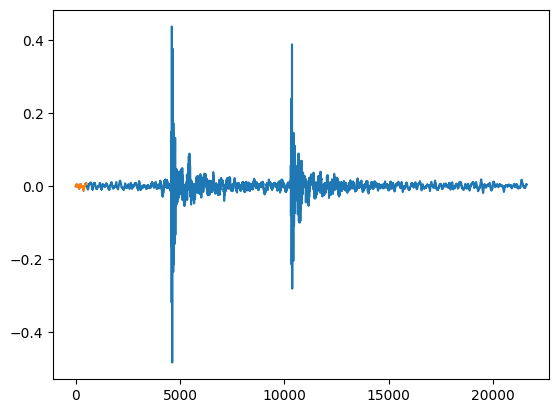

In [58]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

In [96]:
audio, sr = librosa.load(DATA_DIR + 'R-23.wav')
mfcc = librosa.feature.mfcc(y=wav, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
padded_mfcc = pad2d(mfcc, 40)
padded_mfcc= np.expand_dims(padded_mfcc, 0)
     

/home/hyochung/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/hyochung/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


In [97]:
def get_prediction(prediction_value):
  if prediction_value == 0:
    return 'Q'
  elif prediction_value == 1:
    return 'W'
  elif prediction_value == 2:
    return 'E'
  elif prediction_value == 3:
    return 'R'

prediction = model.predict(padded_mfcc)
print(prediction)
prediction_value = np.argmax(prediction)

print(f"The model predicts the label: {get_prediction(prediction_value)}")

1/1 [==============================] - 0s 17ms/step
[[8.5005569e-01 1.1545413e-03 5.3924767e-05 1.4873590e-01]]
The model predicts the label: Q
